In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

In [2]:
# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# === STEP 3A: StandardScaler (for classical ML)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

df_train_std = pd.concat([ids_train.reset_index(drop=True), y_train.reset_index(drop=True), 
                          pd.DataFrame(X_train_std, columns=X.columns)], axis=1)

df_test_std = pd.concat([ids_test.reset_index(drop=True), y_test.reset_index(drop=True), 
                         pd.DataFrame(X_test_std, columns=X.columns)], axis=1)

# === STEP 3B: MinMaxScaler (for neural networks)
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

df_train_mm = pd.concat([ids_train.reset_index(drop=True), y_train.reset_index(drop=True), 
                         pd.DataFrame(X_train_mm, columns=X.columns)], axis=1)

df_test_mm = pd.concat([ids_test.reset_index(drop=True), y_test.reset_index(drop=True), 
                        pd.DataFrame(X_test_mm, columns=X.columns)], axis=1)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# === SETUP ===
X_train_fs = df_train_std.drop(columns=['Subject_ID', 'Label'])  # feature selection on train only
y_train_fs = df_train_std['Label']
feature_names = X_train_fs.columns

# === 1. SelectKBest: ANOVA F-test ===
skb_anova = SelectKBest(score_func=f_classif, k='all')
skb_anova.fit(X_train_fs, y_train_fs)
anova_scores = skb_anova.scores_

# === 2. SelectKBest: Mutual Info ===
skb_mi = SelectKBest(score_func=mutual_info_classif, k='all')
skb_mi.fit(X_train_fs, y_train_fs)
mi_scores = skb_mi.scores_

# === 3. Recursive Feature Elimination (RFE) ===
rfe_model = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)
rfe_model.fit(X_train_fs, y_train_fs)
rfe_ranks = ~rfe_model.support_  # False = selected → 0

# === 4. Random Forest Feature Importances ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_fs, y_train_fs)
rf_scores = rf.feature_importances_

# === Create Comparison Table ===
scores_df = pd.DataFrame({
    'Feature': feature_names,
    'ANOVA_F': anova_scores,
    'Mutual_Info': mi_scores,
    'RF_Importance': rf_scores,
    'RFE_Rank': rfe_ranks.astype(int)
}).sort_values(by='RF_Importance', ascending=False).reset_index(drop=True)

# === Top Features ===
top_anova = scores_df.nlargest(20, 'ANOVA_F')['Feature'].tolist()
top_mi = scores_df.nlargest(20, 'Mutual_Info')['Feature'].tolist()
top_rf = scores_df.nlargest(20, 'RF_Importance')['Feature'].tolist()
top_rfe = scores_df[scores_df['RFE_Rank'] == 0]['Feature'].tolist()

# === Output ===
print("🔥 Top 20 Features by ANOVA:\n", top_anova)
print("\n🔍 Top 20 Features by Mutual Info:\n", top_mi)
print("\n🌲 Top 20 Features by Random Forest:\n", top_rf)
print("\n🧹 Top Features selected by RFE:\n", top_rfe)


🔥 Top 20 Features by ANOVA:
 ['Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Go_precuneus_R_L_to_SMA_R_L', 'SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Stop_Precentral_MFG_R_L_to_precuneus_R_L', 'SST_Stop_Middle_frontal_R_L_to_precuneus_R_L', 'SST_Go_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_precuneus_R_L_to_SMA_R_L', 'SCAP_precuneus_R_L_to_SMA_R_L', 'SCAP_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_occipital_sup_R_L_to_Precentral_MFG_R_L', 'SCAP_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Go_Middle_frontal_R_L_to_SMA_R_L', 'Rest_cingulum_ant_mid_pos_to_precuneus_R_L', 'SCAP_Precentral_MFG_R_L_to_SMA_R_L', 'Rest_occipital_sup_R_L_to_SMA_R_L', 'SCAP_occipital_sup_R_L_to_SMA_R_L']

🔍 Top 20 Features by Mutual Info:
 ['SST_Go_Precentral_MFG_R_L_to_SMA_R_L', 'SST_Stop_ci


🔝 Top 20 Features by Importance:
                                              Feature  Importance
52       SST_Stop_Middle_frontal_R_L_to_precuneus_R_L    0.038164
1      Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L    0.037119
18         SCAP_cingulum_ant_mid_pos_to_precuneus_R_L    0.031665
46  SST_Stop_cingulum_ant_mid_pos_to_occipital_sup...    0.031449
49           SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L    0.030704
33       SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L    0.028256
48     SST_Stop_cingulum_ant_mid_pos_to_precuneus_R_L    0.026641
57       SST_Stop_Precentral_MFG_R_L_to_precuneus_R_L    0.022600
11                  Rest_occipital_sup_R_L_to_SMA_R_L    0.022013
44                    SST_Go_precuneus_R_L_to_SMA_R_L    0.021845
16     SCAP_cingulum_ant_mid_pos_to_occipital_sup_R_L    0.021076
43               SST_Go_Precentral_MFG_R_L_to_SMA_R_L    0.020277
10            Rest_occipital_sup_R_L_to_precuneus_R_L    0.020193
50   SST_Stop_Middle_frontal_R_L_to_occipi

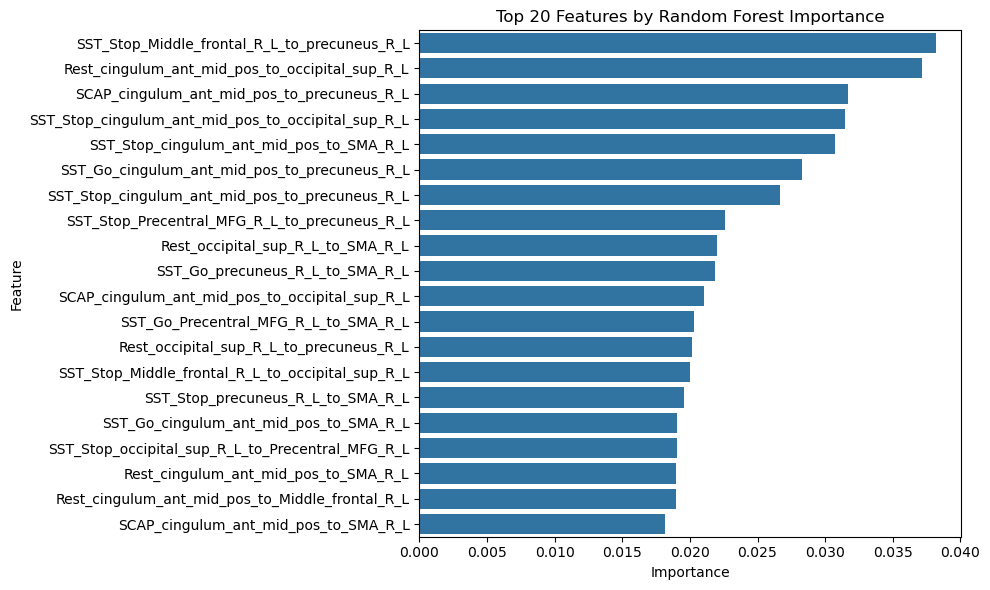

In [5]:
# Fit Random Forest separately to extract top 20 features
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_train_std, y_train)

# Get importances and feature names
importances = rf_full.feature_importances_
feat_names = X.columns  # assuming you have original column names in X

# Create DataFrame
feature_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
top_features = feature_df.sort_values(by='Importance', ascending=False).head(20)
print("\n🔝 Top 20 Features by Importance:")
print(top_features)

# Optional: Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title("Top 20 Features by Random Forest Importance")
plt.tight_layout()
plt.show()


# RF(Feature selection) -->  Random forrest( main classifier)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


e:\anaconda\envs\basic\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


✅ Best Params (Random Forest): {'rf__bootstrap': False, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}

🌲 Random Forest — Train Set
Accuracy: 1.0
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127



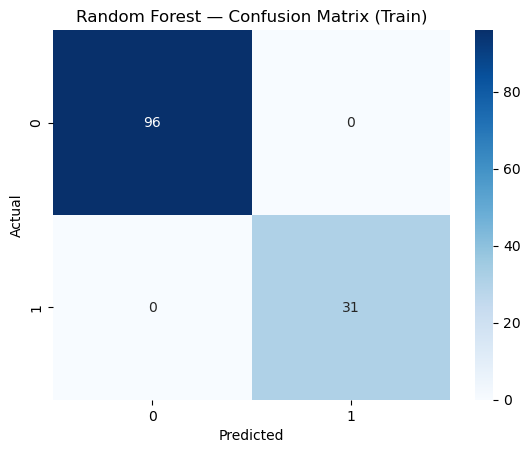

ROC AUC: 1.0


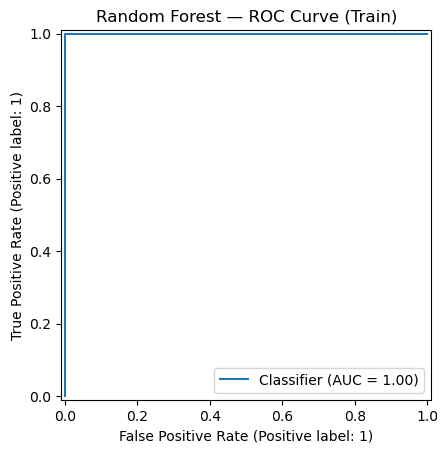

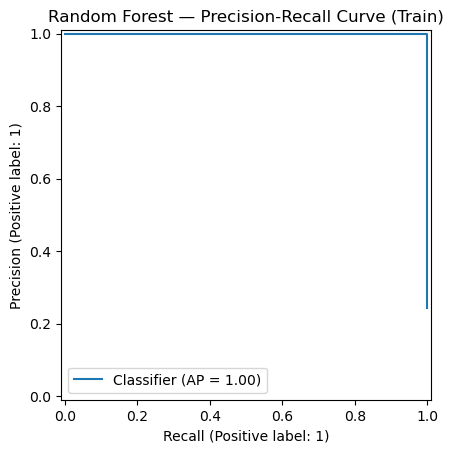

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classificati


📊 Cross-Validated Scores:
fit_time: 0.4656
score_time: 0.0563
test_accuracy: 0.7468
train_accuracy: 1.0000
test_precision: 0.2667
train_precision: 1.0000
test_recall: 0.1250
train_recall: 1.0000
test_f1: 0.1567
train_f1: 1.0000
test_roc_auc: 0.5007
train_roc_auc: 1.0000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

# === Stratified CV Setup ===
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector using Random Forest ===
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), 
                                   max_features=20, threshold=-np.inf)

# === Random Forest Classifier ===
rf = RandomForestClassifier(random_state=42, class_weight=None)

# === Pipeline ===
pipeline_rf = Pipeline([
    ('select', feature_selector),
    ('rf', rf)
])

# === Hyperparameter Grid ===
param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

# === Grid Search ===
grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='f1',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

# === Fit Model ===
grid_rf.fit(X_train_std, y_train)

# === Results ===
print("✅ Best Params (Random Forest):", grid_rf.best_params_)

# === Train Set Evaluation ===
y_pred_rf = grid_rf.predict(X_train_std)
y_proba_rf = grid_rf.predict_proba(X_train_std)[:, 1]

print("\n🌲 Random Forest — Train Set")
print("Accuracy:", accuracy_score(y_train, y_pred_rf))
print(classification_report(y_train, y_pred_rf, target_names=['Control', 'ADHD']))

sns.heatmap(confusion_matrix(y_train, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest — Confusion Matrix (Train)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

print("ROC AUC:", roc_auc_score(y_train, y_proba_rf))
RocCurveDisplay.from_predictions(y_train, y_proba_rf)
plt.title("Random Forest — ROC Curve (Train)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_proba_rf)
plt.title("Random Forest — Precision-Recall Curve (Train)")
plt.show()

# === Cross-Validated Performance ===
cv_results_rf = cross_validate(
    grid_rf.best_estimator_,
    X_train_std, y_train,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv_strategy,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for key, value in cv_results_rf.items():
    print(f"{key}: {np.mean(value):.4f}")


Fitting 10 folds for each of 288 candidates, totalling 2880 fits
✅ Best Params (Random Forest): {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🌲 Random Forest — Train Set
Accuracy: 1.0
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127



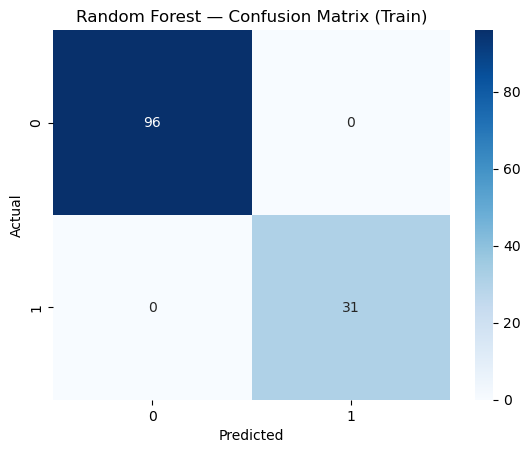

ROC AUC: 1.0


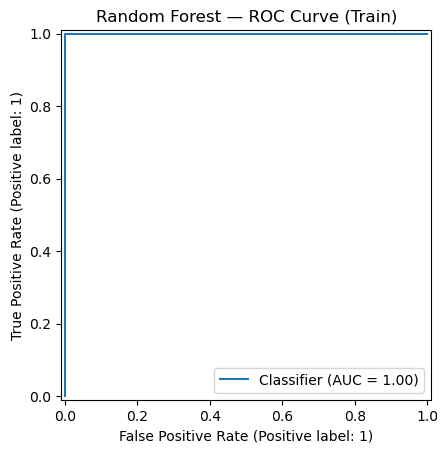

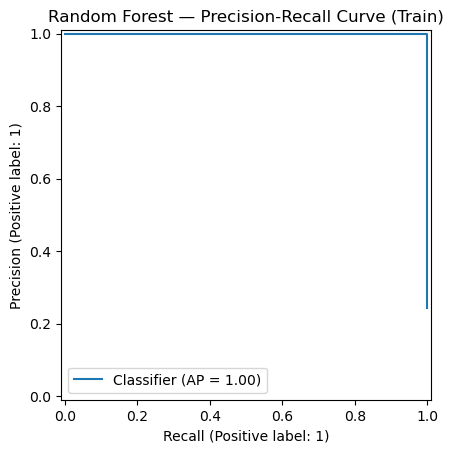

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classificati


📊 Cross-Validated Scores:
fit_time: 0.1778
score_time: 0.0276
test_accuracy: 0.7718
train_accuracy: 1.0000
test_precision: 0.2000
train_precision: 1.0000
test_recall: 0.0667
train_recall: 1.0000
test_f1: 0.1000
train_f1: 1.0000
test_roc_auc: 0.5028
train_roc_auc: 1.0000

🔥 Top 20 Important Features:
                                              Feature  Importance
1      Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L    0.047424
49           SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L    0.035555
48     SST_Stop_cingulum_ant_mid_pos_to_precuneus_R_L    0.032631
18         SCAP_cingulum_ant_mid_pos_to_precuneus_R_L    0.032365
46  SST_Stop_cingulum_ant_mid_pos_to_occipital_sup...    0.031477
52       SST_Stop_Middle_frontal_R_L_to_precuneus_R_L    0.029680
44                    SST_Go_precuneus_R_L_to_SMA_R_L    0.026447
33       SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L    0.025831
3          Rest_cingulum_ant_mid_pos_to_precuneus_R_L    0.025162
10            Rest_occipital_sup_R_L_t

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

# === Stratified CV Setup ===
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Random Forest Classifier ===
rf = RandomForestClassifier(random_state=42, class_weight=None)

# === Hyperparameter Grid ===
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# === Grid Search ===
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='f1',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

# === Fit Model ===
grid_rf.fit(X_train_std, y_train)

# === Results ===
print("✅ Best Params (Random Forest):", grid_rf.best_params_)

# === Train Set Evaluation ===
y_pred_rf = grid_rf.predict(X_train_std)
y_proba_rf = grid_rf.predict_proba(X_train_std)[:, 1]

print("\n🌲 Random Forest — Train Set")
print("Accuracy:", accuracy_score(y_train, y_pred_rf))
print(classification_report(y_train, y_pred_rf, target_names=['Control', 'ADHD']))

sns.heatmap(confusion_matrix(y_train, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest — Confusion Matrix (Train)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

print("ROC AUC:", roc_auc_score(y_train, y_proba_rf))
RocCurveDisplay.from_predictions(y_train, y_proba_rf)
plt.title("Random Forest — ROC Curve (Train)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_proba_rf)
plt.title("Random Forest — Precision-Recall Curve (Train)")
plt.show()

# === Cross-Validated Performance ===
cv_results_rf = cross_validate(
    grid_rf.best_estimator_,
    X_train_std, y_train,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv_strategy,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for key, value in cv_results_rf.items():
    print(f"{key}: {np.mean(value):.4f}")

# === Top 20 Features by Importance ===
importances = grid_rf.best_estimator_.feature_importances_
feature_names = X_train.columns
top_features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

print("\n🔥 Top 20 Important Features:")
print(top_features_df)
